In [ ]:
import numpy as np
import pickle
import time
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_score, mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras import layers, models
from keras.optimizers import Adam
import kerastuner as kt
import tensorflow as tf
import pickle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


Trial 3 Complete [00h 05m 10s]
val_loss: 0.04876807828744253

Best val_loss So Far: 0.04547028491894404
Total elapsed time: 00h 19m 04s

Best hyperparameters: {'dropout_mut_1': 0.2, 'dropout_mut_2': 0.2, 'dropout_exp_1': 0.30000000000000004, 'dropout_exp_2': 0.2, 'dropout_cna_1': 0.4, 'dropout_cna_2': 0.4, 'dropout_meth_1': 0.2, 'dropout_meth_2': 0.30000000000000004, 'units_gene_1': 150, 'dropout_gene_1': 0.4, 'units_gene_2': 75, 'dropout_gene_2': 0.30000000000000004, 'units_gene_3': 30, 'dense_layer_dim_1': 150, 'dropout_merged_1': 0.30000000000000004, 'dense_layer_dim_2': 100, 'dropout_merged_2': 0.30000000000000004, 'learning_rate': 8.773696815258874e-05}
Epoch 1/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 10.7353 - val_loss: 0.1840
Epoch 2/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1759 - val_loss: 0.0843
Epoch 3/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1067 - val_loss: 0.0650
Epoch 4/10
1826/1826 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.080

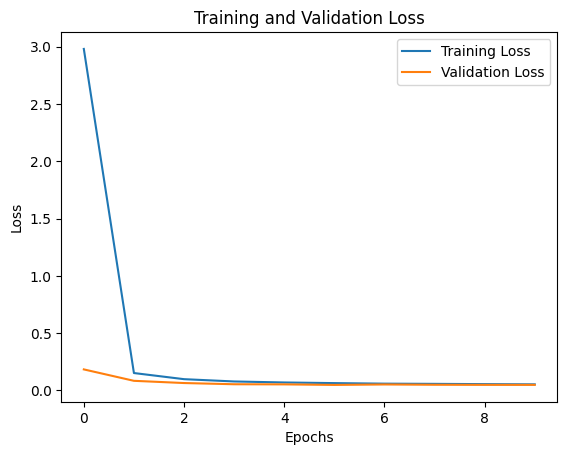


Evaluation metrics on test data:
MSE: 0.0487
RMSE: 0.2207
R-squared (R2): 0.7335
MAE: 0.1692

Binary Classification Metrics:
F1 Score: 0.6824
Recall (Sensitivity): 0.5445
Precision: 0.9140
Accuracy: 0.9517

Final training loss: 0.0535
Final validation loss: 0.0489


In [ ]:

# Load data
with open('/content/drive/MyDrive/Colab Notebooks/Thesis/data/ccl_complete_data_28CCL_1298DepOI_36344samples_demo.pickle', 'rb') as f:
    data_mut, data_exp, data_cna, data_meth, data_dep, data_fprint = pickle.load(f)

premodel_mut = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_mut_100_50_25_demo.pickle', 'rb'))
premodel_exp = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_exp_100_50_25_demo.pickle', 'rb'))
premodel_cna = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_cna_100_50_25_demo.pickle', 'rb'))
premodel_meth = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_meth_100_50_25_demo.pickle', 'rb'))

print("\n\nDatasets successfully loaded.")

# model parameters
num_DepOI = 1298
num_ccl = int(data_mut.shape[0] / num_DepOI)

id_rand = np.random.permutation(num_ccl)
id_cell_train = id_rand[np.arange(0, round(num_ccl * 0.9))]
id_cell_test = id_rand[np.arange(round(num_ccl * 0.9), num_ccl)]

id_train = np.arange(0, 1298) + id_cell_train[0] * 1298
for y in id_cell_train:
    id_train = np.union1d(id_train, np.arange(0, 1298) + y * 1298)

id_test = np.arange(0, 1298) + id_cell_test[0] * 1298
for y in id_cell_test:
    id_test = np.union1d(id_test, np.arange(0, 1298) + y * 1298)

print("\n\nTraining/validation on %d samples (%d CCLs x %d DepOIs) and testing on %d samples (%d CCLs x %d DepOIs).\n\n" % (
    len(id_train), len(id_cell_train), num_DepOI, len(id_test), len(id_cell_test), num_DepOI))

def build_model(hp):
    # subnetworks
    input_mut = layers.Input(shape=(premodel_mut[0][0].shape[0],))
    x = layers.Dense(100, activation='relu', kernel_initializer='he_uniform')(input_mut)
    x = layers.Dropout(hp.Float('dropout_mut_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(50, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(hp.Float('dropout_mut_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(25, activation='relu', kernel_initializer='he_uniform')(x)

    model_mut = models.Model(input_mut, x)
    model_mut.layers[1].set_weights(premodel_mut[0])
    model_mut.layers[3].set_weights(premodel_mut[1])
    model_mut.layers[5].set_weights(premodel_mut[2])

    input_exp = layers.Input(shape=(premodel_exp[0][0].shape[0],))
    x = layers.Dense(100, activation='relu', kernel_initializer='he_uniform')(input_exp)
    x = layers.Dropout(hp.Float('dropout_exp_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(50, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(hp.Float('dropout_exp_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(25, activation='relu', kernel_initializer='he_uniform')(x)

    model_exp = models.Model(input_exp, x)
    model_exp.layers[1].set_weights(premodel_exp[0])
    model_exp.layers[3].set_weights(premodel_exp[1])
    model_exp.layers[5].set_weights(premodel_exp[2])

    input_cna = layers.Input(shape=(premodel_cna[0][0].shape[0],))
    x = layers.Dense(100, activation='relu', kernel_initializer='he_uniform')(input_cna)
    x = layers.Dropout(hp.Float('dropout_cna_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(50, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(hp.Float('dropout_cna_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(25, activation='relu', kernel_initializer='he_uniform')(x)

    model_cna = models.Model(input_cna, x)
    model_cna.layers[1].set_weights(premodel_cna[0])
    model_cna.layers[3].set_weights(premodel_cna[1])
    model_cna.layers[5].set_weights(premodel_cna[2])

    input_meth = layers.Input(shape=(premodel_meth[0][0].shape[0],))
    x = layers.Dense(100, activation='relu', kernel_initializer='he_uniform')(input_meth)
    x = layers.Dropout(hp.Float('dropout_meth_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(50, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(hp.Float('dropout_meth_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(25, activation='relu', kernel_initializer='he_uniform')(x)

    model_meth = models.Model(input_meth, x)
    model_meth.layers[1].set_weights(premodel_meth[0])
    model_meth.layers[3].set_weights(premodel_meth[1])
    model_meth.layers[5].set_weights(premodel_meth[2])

    input_gene = layers.Input(shape=(data_fprint.shape[1],))
    x = layers.Dense(units=hp.Int('units_gene_1', min_value=50, max_value=200, step=50), activation='relu', kernel_initializer='he_uniform')(input_gene)
    x = layers.Dropout(hp.Float('dropout_gene_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(units=hp.Int('units_gene_2', min_value=25, max_value=100, step=25), activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(hp.Float('dropout_gene_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(units=hp.Int('units_gene_3', min_value=10, max_value=50, step=10), activation='relu', kernel_initializer='he_uniform')(x)

    model_gene = models.Model(input_gene, x)

    # Merging subnetworks
    merged = layers.concatenate([model_mut.output, model_exp.output, model_cna.output, model_meth.output, model_gene.output])
    x = layers.Dense(units=hp.Int('dense_layer_dim_1', min_value=50, max_value=200, step=50), activation='relu', kernel_initializer='he_uniform')(merged)
    x = layers.Dropout(hp.Float('dropout_merged_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(units=hp.Int('dense_layer_dim_2', min_value=50, max_value=200, step=50), activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(hp.Float('dropout_merged_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    output = layers.Dense(1, activation='linear', kernel_initializer='he_uniform')(x)

    model_final = models.Model(inputs=[model_mut.input, model_exp.input, model_cna.input, model_meth.input, model_gene.input], outputs=output)

    model_final.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='mse'
    )
    return model_final

# tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  
    executions_per_trial=3, 
    directory='my_dir',
    project_name='deepdep_hyperparameter_tuning'
)

# early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Executing tuner search
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=3,  
    executions_per_trial=3,  
    directory='my_dir',
    project_name='deepdep_hyperparameter_tuning'
)

tuner.search(
    [data_mut[id_train], data_exp[id_train], data_cna[id_train], data_meth[id_train], data_fprint[id_train]],
    data_dep[id_train],
    epochs=10,
    validation_split=0.1,
    batch_size=16
)

# finding the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest hyperparameters: {best_hps.values}")

#  model training
best_model = build_model(best_hps)

history = best_model.fit(
    [data_mut[id_train], data_exp[id_train], data_cna[id_train], data_meth[id_train], data_fprint[id_train]],
    data_dep[id_train],
    epochs=10,
    validation_split=0.1,
    batch_size=16,
    shuffle=True
)

y_pred = best_model.predict(
    [data_mut[id_test], data_exp[id_test], data_cna[id_test], data_meth[id_test], data_fprint[id_test]],
    batch_size=16
)

# evaluation metrics
mse = mean_squared_error(data_dep[id_test], y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(data_dep[id_test], y_pred)
mae = mean_absolute_error(data_dep[id_test], y_pred)

# Plotting 
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# evaluation metrics
print(f"\nEvaluation metrics on test data:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"MAE: {mae:.4f}")

val_predictions = model_final.predict(
    [data_mut[id_train], data_exp[id_train], data_cna[id_train], data_meth[id_train], data_fprint[id_train]],
    batch_size=batch_size)

# evaluation metrics for validation data
val_mse = mean_squared_error(data_dep[id_train], val_predictions)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(data_dep[id_train], val_predictions)
val_mae = mean_absolute_error(data_dep[id_train], val_predictions)

print(f"\nEvaluation metrics on validation data:")
print(f"MSE: {val_mse:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"R-squared (R2): {val_r2:.4f}")
print(f"MAE: {val_mae:.4f}")

# Binary classification metrics
y_true_binary = np.where(data_dep[id_test] < -1, 1, 0)
y_pred_binary = np.where(y_pred < -1, 1, 0)

f1 = f1_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
precision = precision_score(y_true_binary, y_pred_binary)
accuracy = accuracy_score(y_true_binary, y_pred_binary)

print(f"\nBinary Classification Metrics:")
print(f"F1 Score: {f1:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")

print(f"\nFinal training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

In [ ]:
# Get the best hyperparameters and build the model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest hyperparameters: {best_hps.values}")

# Build and train the model with the best hyperparameters
best_model = build_model(best_hps)

history = best_model.fit(
    [data_mut[id_train], data_exp[id_train], data_cna[id_train], data_meth[id_train], data_fprint[id_train]],
    data_dep[id_train],
    epochs=10,
    validation_split=0.1,
    batch_size=16,
    shuffle=True
)

# Evaluate on test data
y_pred = best_model.predict(
    [data_mut[id_test], data_exp[id_test], data_cna[id_test], data_meth[id_test], data_fprint[id_test]],
    batch_size=16
)

# Calculate evaluation metrics
mse = mean_squared_error(data_dep[id_test], y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(data_dep[id_test], y_pred)
mae = mean_absolute_error(data_dep[id_test], y_pred)

# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print evaluation metrics
print(f"\nEvaluation metrics on test data:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"MAE: {mae:.4f}")

# Binary classification metrics
y_true_binary = np.where(data_dep[id_test] < -1, 1, 0)
y_pred_binary = np.where(y_pred < -1, 1, 0)

f1 = f1_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
precision = precision_score(y_true_binary, y_pred_binary)
accuracy = accuracy_score(y_true_binary, y_pred_binary)

print(f"\nBinary Classification Metrics:")
print(f"F1 Score: {f1:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")

print(f"\nFinal training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")